In [17]:
import duckdb
import pandas as pd
import plotly.express as px
import os
from dotenv import load_dotenv

In [18]:
# Actual API key is stored in a .env file.  Not good to store API key directly in script.
load_dotenv()
token = os.environ.get("mdtoken")

In [19]:
# Initiate a MotherDuck connection using an access token
con = duckdb.connect(f"md:raw?motherduck_token={token}") 

In [1]:
# Step 1: Query the DuckDB table into a Pandas DataFrame
query = """
SELECT 
    *
    --, log(close) as log_close
from dolt.vw_pricing a 
where a.act_symbol ='SPCB' and a.adj = true
order by date asc
"""
df = con.execute(query).fetchdf()
df.tail()

NameError: name 'con' is not defined

In [24]:
# Step 2: Plot the data using Plotly Express
fig = px.line(df, x='date', y='close')
fig.show()

In [31]:
con.sql("select * from dolt.ohlcv limit 10")

┌────────────┬────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────┐
│    date    │ act_symbol │     open     │     high     │     low      │    close     │  volume  │
│    date    │  varchar   │ decimal(7,2) │ decimal(7,2) │ decimal(7,2) │ decimal(7,2) │  int64   │
├────────────┼────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────┤
│ 2011-01-03 │ A          │        41.56 │        42.14 │        41.41 │        41.88 │  3572300 │
│ 2011-01-03 │ AACG       │         3.67 │         3.76 │         3.67 │         3.70 │     2400 │
│ 2011-01-03 │ AADR       │        29.98 │        30.06 │        29.88 │        30.06 │     1581 │
│ 2011-01-03 │ AAIC       │        24.22 │        24.74 │        24.22 │        24.60 │    37908 │
│ 2011-01-03 │ AAME       │         2.06 │         2.06 │         2.06 │         2.06 │     1400 │
│ 2011-01-03 │ AAON       │        28.56 │        29.08 │        28.52 │        29.01 │   103037 │
│ 2011-01-

In [75]:
con.sql("select * from dolt.pricing a where a.close < 0 and adj = true")

┌────────────┬────────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┬───────────┬─────────┬─────────────────────┐
│    date    │ act_symbol │        open         │        high         │         low         │        close        │  volume   │   adj   │   cum_adj_factor    │
│    date    │  varchar   │       double        │       double        │       double        │       double        │  double   │ boolean │       double        │
├────────────┼────────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼───────────┼─────────┼─────────────────────┤
│ 2015-07-06 │ HCHC       │  -5.183958333333333 │  -5.183958333333333 │  -4.854916666666667 │            -5.02875 │  268867.0 │ true    │ -0.6208333333333333 │
│ 2016-03-18 │ HCHC       │           -2.402625 │ -2.4274583333333335 │ -2.3157083333333333 │           -2.328125 │  206441.0 │ true    │ -0.6208333333333333 │
│ 2015-04-07 │ HCHC       │  -6.43804166

In [7]:
con.sql("select * from dolt.ri where act_symbol = 'FMF' limit 10")

┌────────────┬────────────┬──────────────┬──────────────┬──────────────┬──────────────┬────────┐
│    date    │ act_symbol │     open     │     high     │     low      │    close     │ volume │
│    date    │  varchar   │ decimal(7,2) │ decimal(7,2) │ decimal(7,2) │ decimal(7,2) │ int64  │
├────────────┼────────────┼──────────────┼──────────────┼──────────────┼──────────────┼────────┤
│ 2013-08-02 │ FMF        │        50.05 │        50.12 │        50.05 │        50.06 │   1300 │
│ 2013-08-05 │ FMF        │        49.90 │        50.02 │        49.90 │        50.00 │    648 │
│ 2013-08-06 │ FMF        │        49.88 │        49.88 │        49.88 │        49.88 │    400 │
│ 2013-08-07 │ FMF        │        49.65 │        49.65 │        49.63 │        49.63 │    350 │
│ 2013-08-08 │ FMF        │        49.42 │        49.42 │        49.42 │        49.42 │    175 │
│ 2013-08-09 │ FMF        │        49.50 │        49.53 │        49.50 │        49.53 │    500 │
│ 2013-08-12 │ FMF        │   

In [39]:
con.sql("""
WITH lagged_pricing AS (
    SELECT
        date,
        act_symbol,
        close,
        -- Calculate future close prices for different time horizons
        LEAD(close, 5) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_1w,
        LEAD(close, 10) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_2w,
        LEAD(close, 21) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_1m,
        LEAD(close, 63) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_3m,
        LEAD(close, 126) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_6m
    FROM dolt.pricing
    WHERE adj = true
)
SELECT
    date,
    act_symbol,
    close,
    -- Calculate forward returns
    (close_1w - close) / close AS return_1w,
    (close_2w - close) / close AS return_2w,
    (close_1m - close) / close AS return_1m,
    (close_3m - close) / close AS return_3m,
    (close_6m - close) / close AS return_6m
FROM lagged_pricing
WHERE act_symbol = 'AAPL'
ORDER BY act_symbol, date ASC;
""")

┌────────────┬────────────┬────────────────────┬───────────────────────┬────────────────────────┬──────────────────────┬────────────────────────┬──────────────────────┐
│    date    │ act_symbol │       close        │       return_1w       │       return_2w        │      return_1m       │       return_3m        │      return_6m       │
│    date    │  varchar   │       double       │        double         │         double         │        double        │         double         │        double        │
├────────────┼────────────┼────────────────────┼───────────────────────┼────────────────────────┼──────────────────────┼────────────────────────┼──────────────────────┤
│ 2011-01-03 │ AAPL       │ 10.329771573583992 │   0.03911156962102119 │   0.033619564887580694 │   0.0447552871924022 │    0.03525806353733653 │  0.04153897502806687 │
│ 2011-01-04 │ AAPL       │ 10.383681841832209 │  0.031241510459114333 │    0.02278970086631034 │  0.03667481662591686 │   0.022940626037610396 │  0.054755

# ML

In [56]:
query ="""
WITH price_data AS (
    SELECT
        date,
        act_symbol,
        close,
        -- Calculate forward close prices for return features
        --LEAD(close, 5) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_1w,
        --LEAD(close, 10) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_2w,
        LEAD(close, 21) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_1m,
        --LEAD(close, 63) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_3m,
        --LEAD(close, 126) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_6m
    FROM pricing
),
momentum_features AS (
    SELECT
        date,
        act_symbol,
        close,
        --close_1w,
        ---close_2w,
        close_1m,
        --close_3m,
        --close_6m,
        -- Calculate lagged close prices for momentum features
        LAG(close, 63) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_3m_lag,
        LAG(close, 126) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_6m_lag,
        LAG(close, 189) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_9m_lag,
        LAG(close, 252) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_12m_lag,
        LAG(close, 21) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_12m_1m_lag
    FROM price_data
),
returns_and_momentum AS (
    SELECT
        date,
        act_symbol,
        close,
        -- Forward Returns
        (close_1w - close) / close AS return_1w,
        (close_2w - close) / close AS return_2w,
        (close_1m - close) / close AS return_1m,
        (close_3m - close) / close AS return_3m,
        (close_6m - close) / close AS return_6m,
        -- Momentum Features
        (close - close_3m_lag) / close_3m_lag AS momentum_3m,
        (close - close_6m_lag) / close_6m_lag AS momentum_6m,
        (close - close_9m_lag) / close_9m_lag AS momentum_9m,
        (close - close_12m_lag) / close_12m_lag AS momentum_12m,
        (close_12m_lag - close_12m_1m_lag) / close_12m_1m_lag AS momentum_12m_1m
    FROM momentum_features
)
SELECT *
FROM returns_and_momentum
--WHERE act_symbol = 'AAPL'
ORDER BY act_symbol, date ASC;
"""
con.sql(query)

┌────────────┬────────────┬────────────────────┬─────────────────────────┬───────────────────────┬──────────────────────┬───────────────────────┬───────────────────────┬────────────────────────┬───────────────────────┬──────────────────────┬──────────────────────┬─────────────────────┐
│    date    │ act_symbol │       close        │        return_1w        │       return_2w       │      return_1m       │       return_3m       │       return_6m       │      momentum_3m       │      momentum_6m      │     momentum_9m      │     momentum_12m     │   momentum_12m_1m   │
│    date    │  varchar   │       double       │         double          │        double         │        double        │        double         │        double         │         double         │        double         │        double        │        double        │       double        │
├────────────┼────────────┼────────────────────┼─────────────────────────┼───────────────────────┼──────────────────────┼──────────────────

In [57]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [58]:
df = con.execute(query).fetchdf()

In [63]:
df
# drop rows with NaN value in return_1m and inf values
df = df.replace([float('inf'), -float('inf')], pd.NA)
df = df.dropna(subset=['return_1m'])
# set numerical columns to float
numerical_columns = df.select_dtypes(include=[float]).columns

In [64]:
# df order by return_1m desc
df.sort_values(by='return_1m', ascending=False).head()

,date,act_symbol,close,return_1w,return_2w,return_1m,return_3m,return_6m,momentum_3m,momentum_6m,momentum_9m,momentum_12m,momentum_12m_1m
22078884,2011-01-24,INPX,0.01,3.0,23.0,39689999999.0,289.0,149.0,NaN,NaN,NaN,NaN,NaN
22078889,2011-03-11,INPX,0.01,9719999999.0,29.0,30374999999.0,117449999999.0,124.0,NaN,NaN,NaN,NaN,NaN
22078923,2011-05-26,INPX,0.13,2.846154,15.923077,9034615383.615383,11.307692,3146538460.538462,NaN,NaN,NaN,NaN,NaN
22080731,2017-02-22,INPX,0.21,0.095238,17.571429,7039285713.285714,12.52381,4030714284.714286,-0.125,-1.0,-0.363636,-0.522727,-1.0
22080734,2017-02-24,INPX,0.23,0.043478,6251086955.521739,5916521738.130434,4965652172.913043,3680217390.304348,-0.08,-1.0,-0.258065,-1.0,0.84


In [69]:
# Load your data
data = df

# Specify features and target
features = [
    "momentum_3m", "momentum_6m", "momentum_9m", "momentum_12m", "momentum_12m_1m",
    # "return_1w", "return_2w", "return_1m", "return_3m", "return_6m"
]
target = "return_1m"

# Prepare the dataset
X = data[features]
y = data[target]

# Convert features to numeric
for col in features:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Drop rows with NaN in features or target
X = X.dropna()
y = y.loc[X.index]  # Align the target variable with the remaining rows

# Remove any rows with NaN in the target
y = y.dropna()
X = X.loc[y.index]  # Ensure X and y are aligned

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


/var/folders/yd/36_ylc8x7tx33z1ps2l7yr5r0000gn/T/ipykernel_33511/433280089.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Mean Squared Error: 2575734669312.0


In [72]:
print("Target Min:", y.min())
print("Target Max:", y.max())


Target Min: -21937.306616677284
Target Max: 7039285713.285714


In [73]:
print(X.describe())
print(y.describe())


        momentum_3m   momentum_6m   momentum_9m  momentum_12m  momentum_12m_1m
count  4.315589e+07  4.315589e+07  4.315589e+07  4.315589e+07     4.315589e+07
mean   7.342189e+03  9.840840e+03  1.105958e+04  1.132746e+04     1.113831e+04
std    3.383675e+06  5.128749e+06  5.857559e+06  6.246733e+06     4.276051e+06
min   -2.417544e+04 -3.420500e+04 -2.538710e+04 -1.431485e+04    -3.884408e+04
25%   -8.891596e-02 -1.163895e-01 -1.370441e-01 -1.530864e-01    -1.519301e-01
50%    5.446972e-03  1.069845e-02  1.448894e-02  1.836394e-02    -1.696325e-02
75%    9.684438e-02  1.332544e-01  1.614501e-01  1.863492e-01     1.738149e-01
max    5.592115e+09  8.100000e+09  8.562857e+09  1.788750e+10     5.846087e+09
count     43155891.0
unique    25915902.0
top              0.0
freq        319550.0
Name: return_1m, dtype: float64


In [74]:
print(data['close'].describe())


count    4.695998e+07
mean     1.747317e+04
std      3.932137e+06
min     -6.736608e+05
25%      9.820000e+00
50%      2.250000e+01
75%      4.392000e+01
max      2.430000e+09
Name: close, dtype: float64


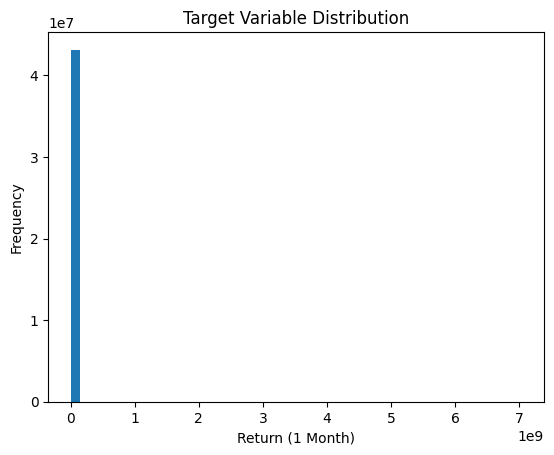

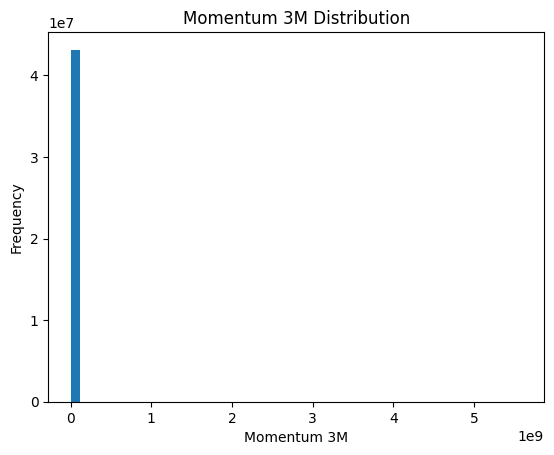

In [71]:
import matplotlib.pyplot as plt

# Plot the target variable
plt.hist(y, bins=50)
plt.title("Target Variable Distribution")
plt.xlabel("Return (1 Month)")
plt.ylabel("Frequency")
plt.show()

# Check a feature
plt.hist(X["momentum_3m"], bins=50)
plt.title("Momentum 3M Distribution")
plt.xlabel("Momentum 3M")
plt.ylabel("Frequency")
plt.show()


# ri

In [12]:
df = con.execute("""
SELECT date, act_symbol, close FROM dolt.vw_pricing WHERE adj=true ORDER BY date;""").df()

In [13]:
# Ensure the data is sorted by act_symbol and date
df = df.sort_values(by=["act_symbol", "date"]).reset_index(drop=True)
df.head()

,date,act_symbol,close
0,2011-01-03,A,41.88
1,2011-01-04,A,41.49
2,2011-01-05,A,41.40
3,2011-01-06,A,41.48
4,2011-01-07,A,41.62


In [14]:
def calculate_return_index(df):
    ri = [100]  # Initialize RI with the first value as 100
    for i in range(1, len(df)):
        ri.append(ri[-1] * (df['close'].iloc[i] / df['close'].iloc[i - 1]))
    df['ri'] = ri
    return df

result_df = df.groupby('act_symbol', group_keys=False).apply(calculate_return_index)

result_df.head()

/var/folders/yd/36_ylc8x7tx33z1ps2l7yr5r0000gn/T/ipykernel_21368/731911062.py:4: RuntimeWarning:

invalid value encountered in scalar divide

/var/folders/yd/36_ylc8x7tx33z1ps2l7yr5r0000gn/T/ipykernel_21368/731911062.py:4: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/yd/36_ylc8x7tx33z1ps2l7yr5r0000gn/T/ipykernel_21368/731911062.py:4: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/yd/36_ylc8x7tx33z1ps2l7yr5r0000gn/T/ipykernel_21368/731911062.py:4: RuntimeWarning:

invalid value encountered in scalar multiply

/var/folders/yd/36_ylc8x7tx33z1ps2l7yr5r0000gn/T/ipykernel_21368/731911062.py:4: RuntimeWarning:

invalid value encountered in scalar divide

/var/folders/yd/36_ylc8x7tx33z1ps2l7yr5r0000gn/T/ipykernel_21368/731911062.py:4: RuntimeWarning:

invalid value encountered in scalar divide

/var/folders/yd/36_ylc8x7tx33z1ps2l7yr5r0000gn/T/ipykernel_21368/731911062.py:4: RuntimeWarning:

divide by zero encountered in scalar divide

/

,date,act_symbol,close,ri
0,2011-01-03,A,41.88,100.000000
1,2011-01-04,A,41.49,99.068768
2,2011-01-05,A,41.40,98.853868
3,2011-01-06,A,41.48,99.044890
4,2011-01-07,A,41.62,99.379179


In [17]:

# Create a DuckDB connection and load the table
con.register("dolt.ri", result_df)

In [ ]:
con.sql("CREATE TABLE dolt.ri AS SELECT * FROM result_df")

In [18]:
con.sql("select * from dolt.ri where act_symbol = 'CRKN' limit 10")

CatalogException: Catalog Error: Table with name ri does not exist!
Did you mean "main.ri"?

In [ ]:
con.sql("s")